# *FinClub Open Project, Summer 2025*
Submission by: $Pradyuman$ $Singh$ $Shekhawat$ <br>
Enrolment: $23115107$

---
# **European Option Pricing: Binomial Tree vs. Black-Scholes**
This project compares **two foundational stochastic methods** for pricing European options. I have implemented both models, analyzed their convergence, and compared their performance based on time, tested for sensitivity with the various parameters. I have tried to keep the code **modular** and ensured proper **error handling**, trying to catch as many **edge cases** as I could!
<br><br>



### **Assumptions**

1.   **No Arbitrage** opportunities
2.   **Risk-Neutral Valuation**: Investors do not increase the expected return they require from an investment to compensate for increased risk. The world we live in is, of course, not a risk-neutral world. The
higher the risks investors take, the higher the expected returns they require. However, it
turns out that assuming a risk-neutral world gives us the right option price for the
world we live in, as well as for a risk-neutral world.

| Assumption                | Binomial Tree Model                             | Black-Scholes Model                          |
|---------------------------|-------------------------------------------------|----------------------------------------------|
| Time Framework            | Discrete time steps (N periods of length delta t) | Continuous time (no discrete steps)         |
| Price Dynamics            | Evolves via up/down factors in each step         | Follows continuous lognormal diffusion       |
| Volatility                | Constant per-step; converges to sigma as N grows| Assumes constant instantaneous volatility    |
| Interest Rates            | Constant rate per period                        | Constant continuously compounded rate        |
| Dividends                 | Incorporated via per-step yield q               | Continuous dividend yield delta              |
| Early Exercise            | Handles American options naturally <br>(At each step simply take max of either calculated value or <br>value from excercising option)<br>{Not required in our case but adding becuz I read JC Hull!}              | Only European; no early exercise in closed form |
| Convergence               | Converges to Black-Scholes as N increases       | Analytic solution without discretization error |

### **Important**:

1.   The **expected return** on a stock (or any other investment) is the *risk-free rate*.
2.   The **discount rate** used for the expected payoff on an option (or any other
instrument) is the *risk-free rate*.

### **Clarifications**:

1.   I have used **historical volatility** while checking convergence of Binomial Tree with the BS-Formula. Whereas I have used **implied volatility**, while comparing the output of my models to the actual market price.
2. Real-world data may not perfectly align with theoretical assumptions which I will be showing by comparing results obtained from both models to actual market prices.
3. Accuracy of pricing comparison depends on data quality provided by **yfinance** which I have used to source my data.

---


# **Import Libraries and Initial Setup**


---




In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
import time  # For performance timing
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = [8, 5]
sns.set_style("whitegrid")

Set of utility functions for fetching financial data used in my analysis:

1. **fetch_data()** downloads historical adjusted close prices from Yahoo Finance for a given stock and date range.
2. **get_dividend_yield()** retrieves a stock’s dividend yield using reliable Yahoo Finance data or manually estimates it from the most recent dividend and current price if necessary.
3. **get_risk_free_rate()** fetches the latest 3-month Treasury bill yield (used as a proxy for the risk-free rate, especially relevant for ~6-month maturities).
4. **fetch_option_chain()** retrieves the option chain (calls and puts) for a given stock and expiration date; if no date is provided, it defaults to the nearest expiry.

In [4]:
#Data Fetching Functions

def fetch_data(symbol, start, end):
    """Fetch historical price data from Yahoo Finance"""
    df = yf.download(symbol, start=start, end=end, auto_adjust=False)
    return df['Adj Close']

def get_dividend_yield(ticker):
    stock = yf.Ticker(ticker)

    reliable_yield = stock.info.get('trailingAnnualDividendYield', 0)

    # Fallback to manual calculation if needed
    if not reliable_yield or reliable_yield >= 0.1:  # Sanity check
        dividends = stock.dividends
        if len(dividends) > 0:
            last_div = dividends.iloc[-1]
            price = stock.history(period='1d')['Close'].iloc[-1]
            return (last_div * 4) / price  # Annualize quarterly
    return reliable_yield or 0.0  # Default

def get_risk_free_rate():
    tbill = yf.Ticker("^IRX")  # 3-month T-bill ticker because I am using 6 month maturity (See Table Below)
    latest_rate = tbill.history(period="1d")['Close'].iloc[-1]
    return latest_rate / 100

def fetch_option_chain(ticker, expiration=None):
    """Fetch option chain data for a given ticker"""
    stock = yf.Ticker(ticker)

    if expiration is None:
        # Get the nearest expiration
        expirations = stock.options
        if not expirations:
            return None, None, None
        expiration = expirations[0]

    try:
        opt_chain = stock.option_chain(expiration)
        return opt_chain.calls, opt_chain.puts, expiration
    except:
        return None, None, None

Which rate to use as the risk-free rate?

| Maturity     | Recommended Rate     | Python Ticker for yfinance |
|--------------|----------------------|----------------|
| <1 year      | 3-month T-bill yield | ^IRX           |
| 1–5 years    | 2-year Treasury yield| ^TYX           |
| 5+ years     | 10-year Treasury yield| ^TNX          |
  

# **Option Pricing Models**
---




## Black-Scholes-Merton Model

The model has had a huge influence on the way that traders price and hedge derivatives. In
1997, the importance of the model was recognized when Robert Merton and Myron
Scholes were awarded the Nobel prize for economics.<br>
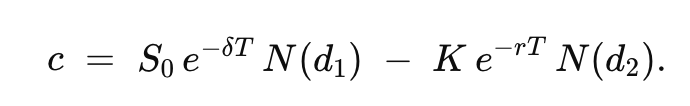
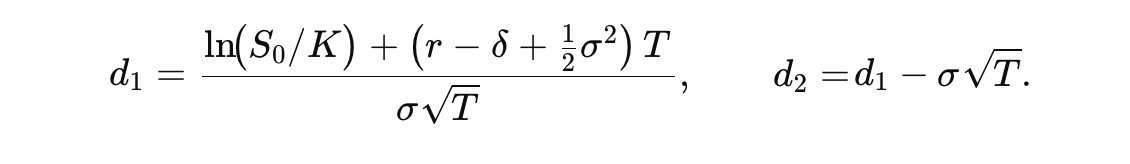
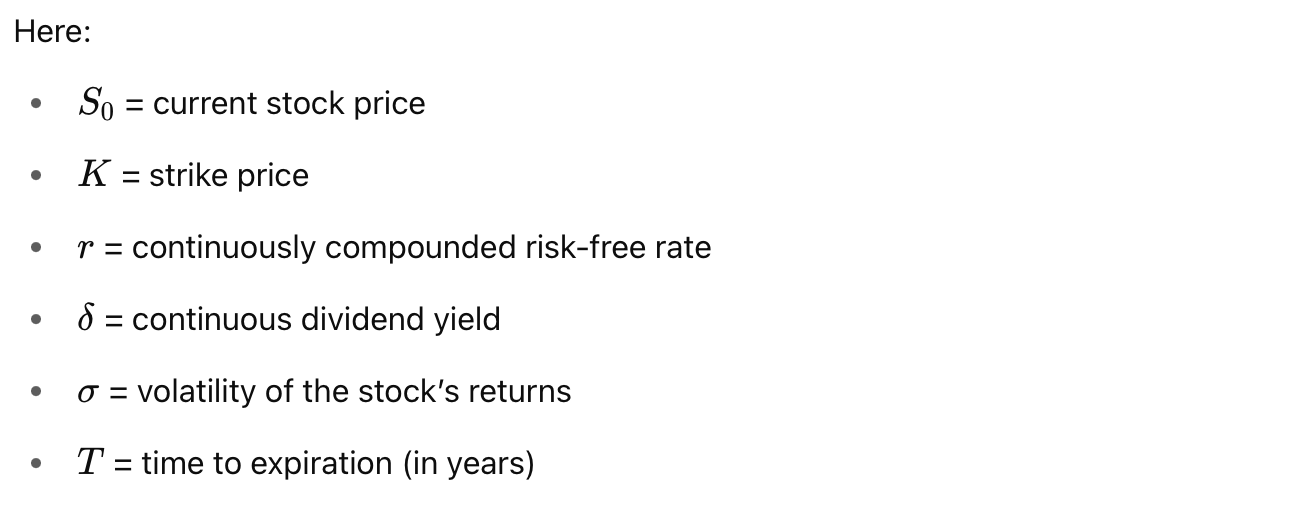


In [5]:
def bs_price(S, K, T, r, sigma, option='call', q=0.0):
    """
    Robust Black-Scholes implementation with error handling
    """
    # Input validation
    if sigma <= 0 or T <= 0:
        return np.nan

    try:
        sqrt_T = np.sqrt(T)
        # Handle case where S=0 or K=0
        if S <= 0 or K <= 0:
            return np.nan

        log_SK = np.log(S/K) if S != K else 0  # Avoid log(1)=0 for ATM options

        d1 = (log_SK + (r - q + 0.5*sigma**2)*T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T

        if option == 'call':
            price = S * np.exp(-q*T)*norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
        else:
            price = K * np.exp(-r*T)*norm.cdf(-d2) - S * np.exp(-q*T)*norm.cdf(-d1)

        return max(price, 0)  # Option prices can't be negative
    except:
        return np.nan

### Black-Scholes Option Greeks (for Sensitivity Analysis)



"Greeks" are used to understand how the option's price responds to different market factors:

- **Delta (Δ)**: Measures how much the option price changes with a $1 change in the underlying stock. (∂V/∂S)
- **Gamma (Γ)**: Measures how much delta itself changes as the stock price changes. Indicates non-linearity. (∂²V/∂S²)
- **Vega (ν)**: Measures sensitivity to volatility. Highest for ATM, long-dated options. (∂V/∂σ)
- **Theta (Θ)**: Represents time decay. Indicates the daily loss in value as expiration nears. (∂V/∂T)
- **Rho (ρ)**: Captures the impact of interest rate changes on option price. More significant for long-term options. (∂V/∂r)

These sensitivities are key to managing options portfolios and performing effective risk management.

In [6]:
def bs_greeks(S, K, T, r, sigma, option='call', q=0.0):
    """
    Calculate Black-Scholes option Greeks

    Returns:
    Dictionary with delta, gamma, vega, theta, rho
    """
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option == 'call':
        delta = np.exp(-q*T) * norm.cdf(d1)
        theta_part = - (S * sigma * np.exp(-q*T) * norm.pdf(d1)) / (2 * np.sqrt(T))
        theta = theta_part - r * K * np.exp(-r*T) * norm.cdf(d2) + q * S * np.exp(-q*T) * norm.cdf(d1)
    else:
        delta = np.exp(-q*T) * (norm.cdf(d1) - 1)
        theta_part = - (S * sigma * np.exp(-q*T) * norm.pdf(d1)) / (2 * np.sqrt(T))
        theta = theta_part + r * K * np.exp(-r*T) * norm.cdf(-d2) - q * S * np.exp(-q*T) * norm.cdf(-d1)

    gamma = (np.exp(-q*T) * norm.pdf(d1)) / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q*T) * norm.pdf(d1) * np.sqrt(T)

    if option == 'call':
        rho = K * T * np.exp(-r*T) * norm.cdf(d2)
    else:
        rho = -K * T * np.exp(-r*T) * norm.cdf(-d2)

    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta / 365,  # per day
        'rho': rho
    }

## Binomial Tree Model

A useful and very popular technique for pricing an option involves constructing a
**binomial tree**. This is a diagram representing different possible paths that might be
followed by the stock price over the life of an option. The underlying assumption is that
the stock price follows a **random walk**. In each time step, it has a certain probability of
moving up by a certain percentage amount and a certain probability of moving down by
a certain percentage amount.

In [7]:
def binomial_price(S, K, T, r, sigma, N, option='call', q=0.0):
    """
    Robust Binomial model implementation with error handling
    """
    # Input validation
    if sigma <= 0 or T <= 0 or N <= 0:
        return np.nan
    if S <= 0 or K <= 0:
        return np.nan

    try:
        S = float(S)
        K = float(K)
        T = float(T)
        r = float(r)
        sigma = float(sigma)
        q = float(q)
        N = int(N)

        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Handle potential numerical instability
        if sigma*sqrt_dt > 1.5:  # Prevent extreme jumps
            sigma_adj = 1.5/sqrt_dt
            print(f"Warning: sigma adjusted from {sigma:.4f} to {sigma_adj:.4f} for stability")
            sigma = sigma_adj

        u = np.exp(sigma * sqrt_dt)
        d = 1/u

        # Handle potential division by zero
        disc = np.exp(-r * dt)
        exp_rq = np.exp((r - q)*dt)
        denominator = u - d

        if denominator == 0:
            return np.nan

        p = (exp_rq - d) / denominator

        # Validate probability
        if p < 0 or p > 1:
            return np.nan

        # Initialize asset prices at maturity
        ST = np.array([S * (u**j) * (d**(N-j)) for j in range(N+1)])

        # Calculate option values at maturity
        if option == 'call':
            values = np.maximum(ST - K, 0)
        else:
            values = np.maximum(K - ST, 0)

        # Backward induction
        for i in range(N-1, -1, -1):
            values = disc * (p * values[1:] + (1-p) * values[:-1])

        return float(values[0])
    except:
        return np.nan


**Interesting Point!**
<br>The option pricing formula in equation does not involve the probabilities of the stock price moving up or down. For example, we get the same option price when the
probability of an upward movement is 0.5 as we do when it is 0.9.
The key reason is that we are not valuing the option in absolute terms. We are
calculating its value in terms of the price of the underlying stock. The probabilities of
future up or down movements are already incorporated into the stock price: we do not
need to take them into account again when valuing the option in terms of the stock price.

### Visualisation Tool

In [8]:
def build_binomial_tree(S, K, T, r, sigma, N, option='call', q=0.0):
    dt = T / N
    u  = np.exp(sigma * np.sqrt(dt))
    d  = 1 / u
    disc = np.exp(-r * dt)
    exp_rq = np.exp((r - q) * dt)
    p  = (exp_rq - d) / (u - d)

    # ---DEBUG---
    if not (0 <= p <= 1):
        print(f"Warning: risk‑neutral p = {p:.4f} outside [0,1].")

    # stock‐price tree
    stock_tree = []
    for i in range(N+1):
        stock_tree.append([S * (u**j) * (d**(i-j)) for j in range(i+1)])

    # option‐value tree, initialize at maturity
    if option.lower() == 'call':
        payoff = lambda ST: max(ST - K, 0)
    else:
        payoff = lambda ST: max(K - ST, 0)
    option_tree = [None]*N + [[payoff(ST) for ST in stock_tree[N]]]

    # backtrack
    for i in range(N-1, -1, -1):
        level_vals = []
        for j in range(i+1):
            v = disc * ( p * option_tree[i+1][j+1] + (1-p) * option_tree[i+1][j] )
            level_vals.append(v)
        option_tree[i] = level_vals

    return stock_tree, option_tree

def visualize_binomial_tree(S, K, T, r, sigma, N, option='call', q=0.0, verbose=True):
    """
    Builds & (optionally) prints the tree, then plots it.
    """
    stock_tree, option_tree = build_binomial_tree(S, K, T, r, sigma, N, option, q)

    if verbose:
        print("\n=== STOCK PRICE TREE ===")
        for i, lvl in enumerate(stock_tree):
            print(f"Step {i}: " + "  ".join(f"{s:.2f}" for s in lvl))
        print("\n=== OPTION VALUE TREE ===")
        for i, lvl in enumerate(option_tree):
            print(f"Step {i}: " + "  ".join(f"{v:.2f}" for v in lvl))
        print()

    # now plot
    fig, ax = plt.subplots(figsize=(2.5*(N+1), 2.5*(N+1)))
    ax.set_axis_off()
    positions = {}

    for i in range(N+1):
        y = -i
        xs = np.linspace(-i, i, i+1)
        for j, x in enumerate(xs):
            positions[(i,j)] = (x,y)
            txt = f"S={stock_tree[i][j]:.2f}\nV={option_tree[i][j]:.2f}"
            ax.text(x, y, txt, ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black'))

    # draw connecting lines
    for i in range(N):
        for j in range(i+1):
            x0, y0 = positions[(i,j)]
            for k in (j, j+1):
                x1, y1 = positions[(i+1,k)]
                ax.plot([x0,x1], [y0,y1], 'k-', lw=1)

    ax.set_title(f"Binomial Tree (N={N})")
    ax.set_xlim(-N-0.5, N+0.5)
    ax.set_ylim(-N-0.5, 0.5)
    plt.show()



=== STOCK PRICE TREE ===
Step 0: 100.00
Step 1: 90.48  110.52
Step 2: 81.87  100.00  122.14
Step 3: 74.08  90.48  110.52  134.99
Step 4: 67.03  81.87  100.00  122.14  149.18

=== OPTION VALUE TREE ===
Step 0: 9.97
Step 1: 3.32  15.92
Step 2: 0.00  6.25  24.61
Step 3: 0.00  0.00  11.76  36.23
Step 4: 0.00  0.00  0.00  22.14  49.18



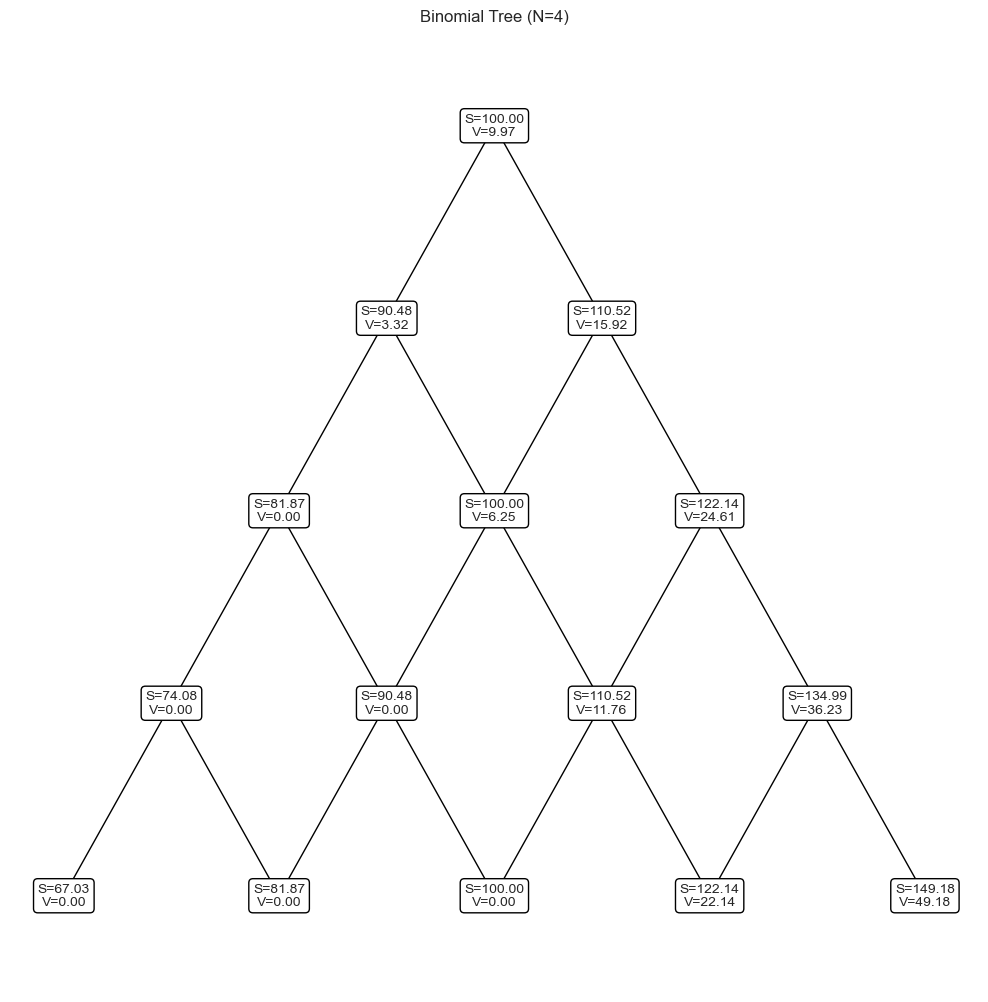

In [9]:
visualize_binomial_tree(
    S=100,    # spot price
    K=100,    # strike
    T=1.0,    # time to maturity
    r=0.05,   # risk‑free rate
    sigma=0.2,# volatility
    N=4,      # # of steps
    option='call',
    q=0.0,    # dividend yield
    verbose=True  # prints the numeric trees
)


# **Testing the Models**
---

## Basic Convergence Test

"SPY" is ticker symbol for the SPDR S&P 500 ETF Trust, one of the world’s largest and most liquid exchange‑traded funds. <br>It’s designed to track the performance of the S&P 500 index—i.e., the 500 largest publicly traded U.S. companies—by holding the same constituents in (approximately) the same weights
<br><br> I chose to run my basic test for the options on this asset

[*********************100%***********************]  1 of 1 completed


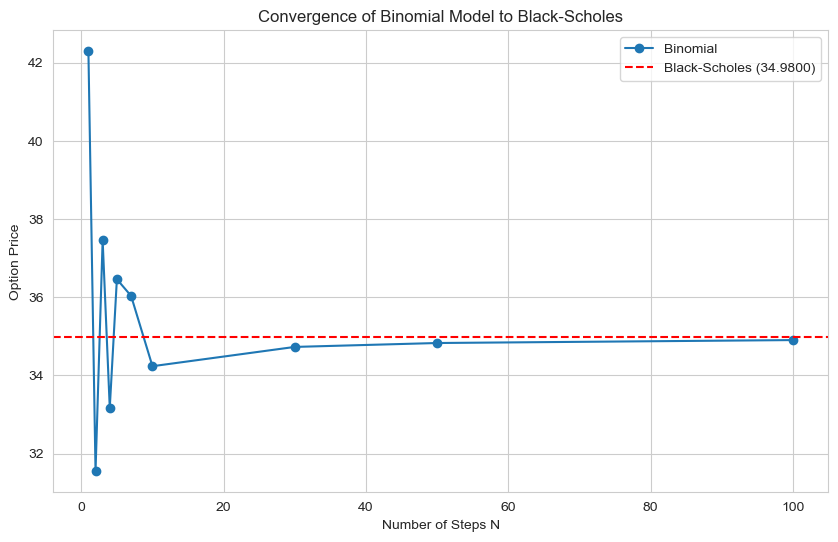

In [10]:
ticker = 'SPY'
spot_series = fetch_data(ticker, '2024-01-01', '2025-06-01')

S0 = spot_series.iloc[-1] #get the latest price
if hasattr(S0, 'iloc'):
    S0 = S0.iloc[0]
else:
    S0 = float(S0)

K = S0  # ATM option
T = 0.5  # 6 months to maturity
r = get_risk_free_rate()
q = get_dividend_yield(ticker)  # dividend yield

# Calculate historical volatility
returns = spot_series.pct_change().dropna()
vol_calc = returns.std() * np.sqrt(252)
if hasattr(vol_calc, 'iloc'):
    sigma = vol_calc.iloc[0]
else:
    sigma = float(vol_calc)

# Test convergence
ns = [1,2,3,4,5,7,10, 30, 50, 100]
bs_val = bs_price(S0, K, T, r, sigma, 'call', q)
binom_vals = [binomial_price(S0, K, T, r, sigma, N, 'call', q) for N in ns]

# Plot convergence
plt.figure(figsize=(10,6))
plt.plot(ns, binom_vals, marker='o', label='Binomial')
plt.axhline(bs_val, color='r', linestyle='--', label=f'Black-Scholes ({bs_val:.4f})')
plt.xlabel('Number of Steps N')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Model to Black-Scholes')
plt.legend()
plt.grid(True)
plt.show()

## Multiple Examples

Trying out other examples, with other combinations including-
<br>1. Both calls and puts
<br>2. Stonks like GOOGL, MSFT, etc. which are Liquid (so bid/ask spreads are tight and prices are reliable)
<br>3. Different Moneyness:
<br>Out of Money (OTM): K>S0
<br>At the Money (ATM): K=S0
<br>In the Money (ITM): K<S0
<br>(S0 is Spot Stock Price taken at t = 0)


[*********************100%***********************]  1 of 1 completed


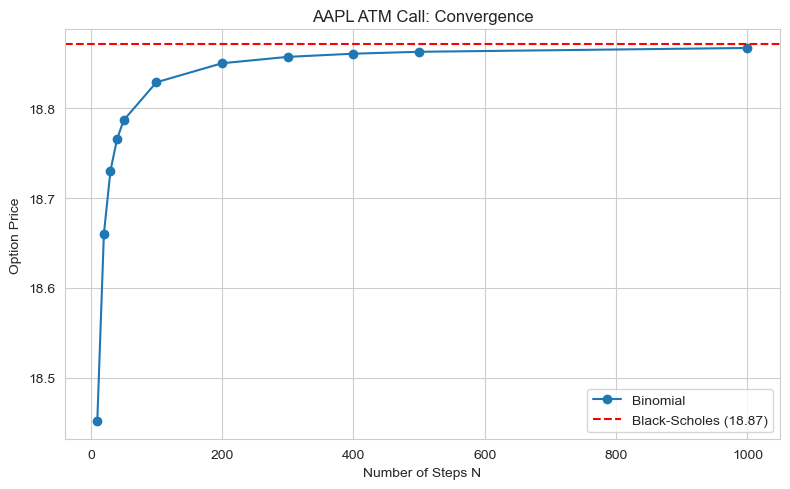

[*********************100%***********************]  1 of 1 completed


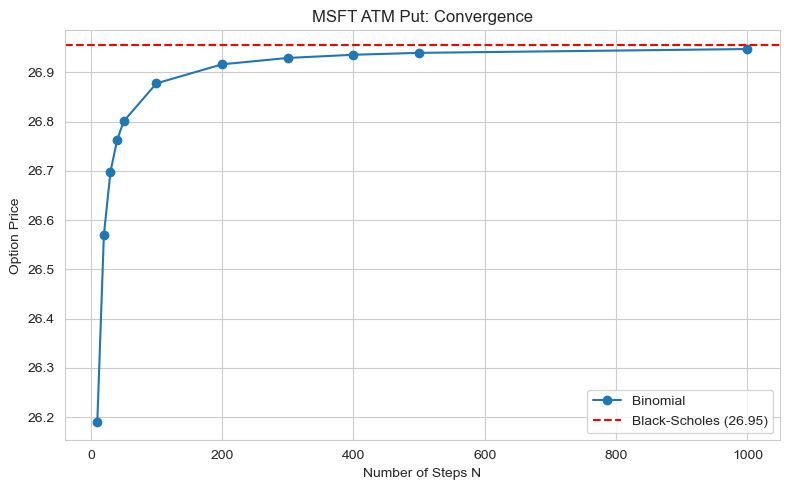

[*********************100%***********************]  1 of 1 completed


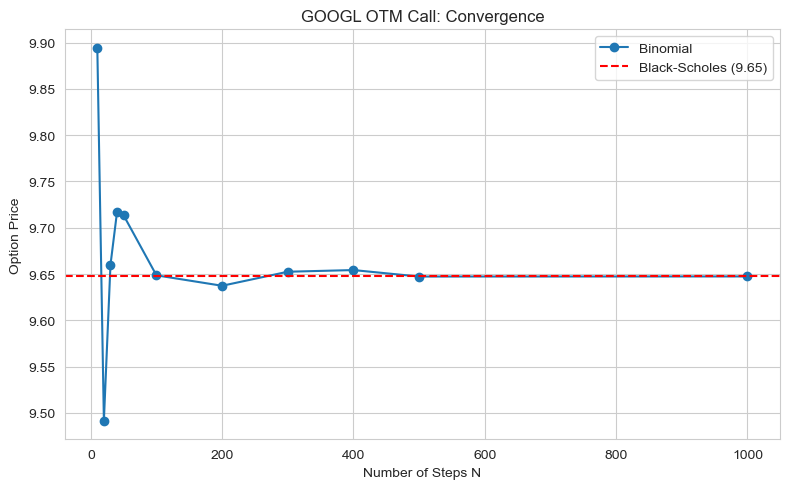

[*********************100%***********************]  1 of 1 completed


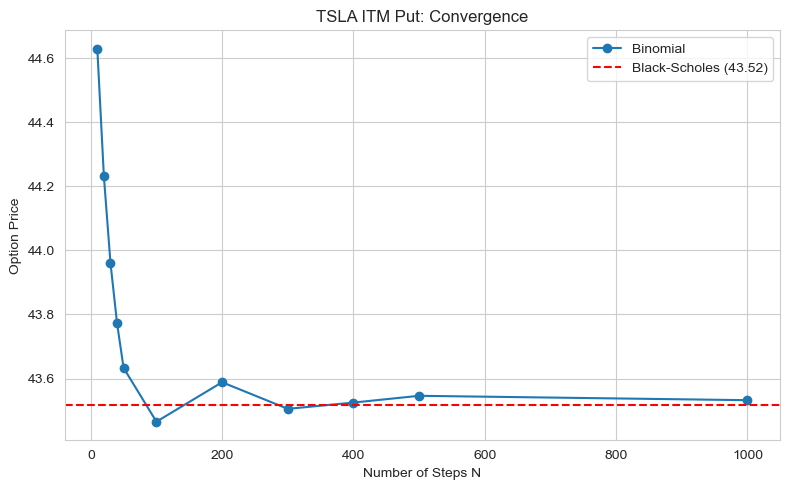

In [11]:
# Define examples
examples = [
    {'Stock':'AAPL', 'Moneyness':'ATM', 'Option':'call'},
    {'Stock':'MSFT', 'Moneyness':'ATM', 'Option':'put'},
    {'Stock':'GOOGL','Moneyness':'OTM','Option':'call'},
    {'Stock':'TSLA','Moneyness':'ITM','Option':'put'}
]

Ns = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000]

for ex in examples:
    sym = ex['Stock']
    opt = ex['Option']
    label = ex['Moneyness']

    spot_series = fetch_data(sym, '2024-01-01', '2025-06-01')
    S0 = spot_series.iloc[-1]
    if hasattr(S0, 'iloc'):
        S0 = S0.iloc[0]
    else:
        S0 = float(S0)

    returns = spot_series.pct_change().dropna()
    vol_calc = returns.std() * np.sqrt(252)
    if hasattr(vol_calc, 'iloc'):
        sigma = vol_calc.iloc[0]
    else:
        sigma = float(vol_calc)

    q_sym = get_dividend_yield(sym)

    # Determine strike based on moneyness
    m = {'ITM':0.9, 'ATM':1.0, 'OTM':1.1}[label]
    K = m * S0

    # Compute prices
    bs_val = bs_price(S0, K, T, r, sigma, opt, q_sym)
    binom_vals = [binomial_price(S0, K, T, r, sigma, N, opt, q_sym) for N in Ns]

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(Ns, binom_vals, 'o-', label='Binomial')
    plt.axhline(bs_val, color='r', linestyle='--',
                label=f'Black-Scholes ({bs_val:.2f})')
    plt.title(f"{sym} {label} {opt.capitalize()}: Convergence")
    plt.xlabel('Number of Steps N')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In practice there really isn’t a single *“magic N”* that everyone uses—<br>traders and risk‑systems pick the step‑count based on the **accuracy** they need versus the **latency they can tolerate**. A few broad trends:

1.   **Light‑latency trading (intra‑day/market‑making)**: 50 – 200 steps used, since even at N≈100 the binomial price is within a few cents of the Black‑Scholes benchmark, and sub‑millisecond response times are critical.
2.   **Middle‑office risk‑reports**: Here latencies of tens to hundreds of milliseconds are acceptable, so many shops bump up to 200 – 500 steps to drive pricing errors below $0.01 on plain‑vanilla calls and puts.

3. **Valuation files / end‑of‑day mark‑to‑market**:
When you’ve got seconds per price to spare, it’s common to see 500 – 1000 steps (or even more) used to ensure convergence.


## Option Greeks: Validation Testing

1. **Benchmark Comparison:**
I have compared calculated Greeks against benchmarks (examples from J.C. Hull)  with % error for both call and put options
2. **Visual Verification:**
I have plotted delta/gamma/vega across strike prices to confirm **expected S-shaped curves for delta** and validates **gamma/vega peak at ATM strikes**


=== CALL Option Greeks Validation ===
Greek      Calculated      Benchmark       Error %   
delta      0.636831        0.636800        0.00      %
gamma      0.018762        0.018800        0.20      %
vega       37.524035       39.663500       5.39      %
theta      -0.017573       -0.011400       -54.15    %
rho        53.232482       53.040300       0.36      %

=== PUT Option Greeks Validation ===
Greek      Calculated      Benchmark       Error %   
delta      -0.363169       -0.363200       -0.01     %
gamma      0.018762        0.018800        0.20      %
vega       37.524035       39.663500       5.39      %
theta      -0.004542       -0.005000       -9.16     %
rho        -41.890461      -41.408100      -1.16     %


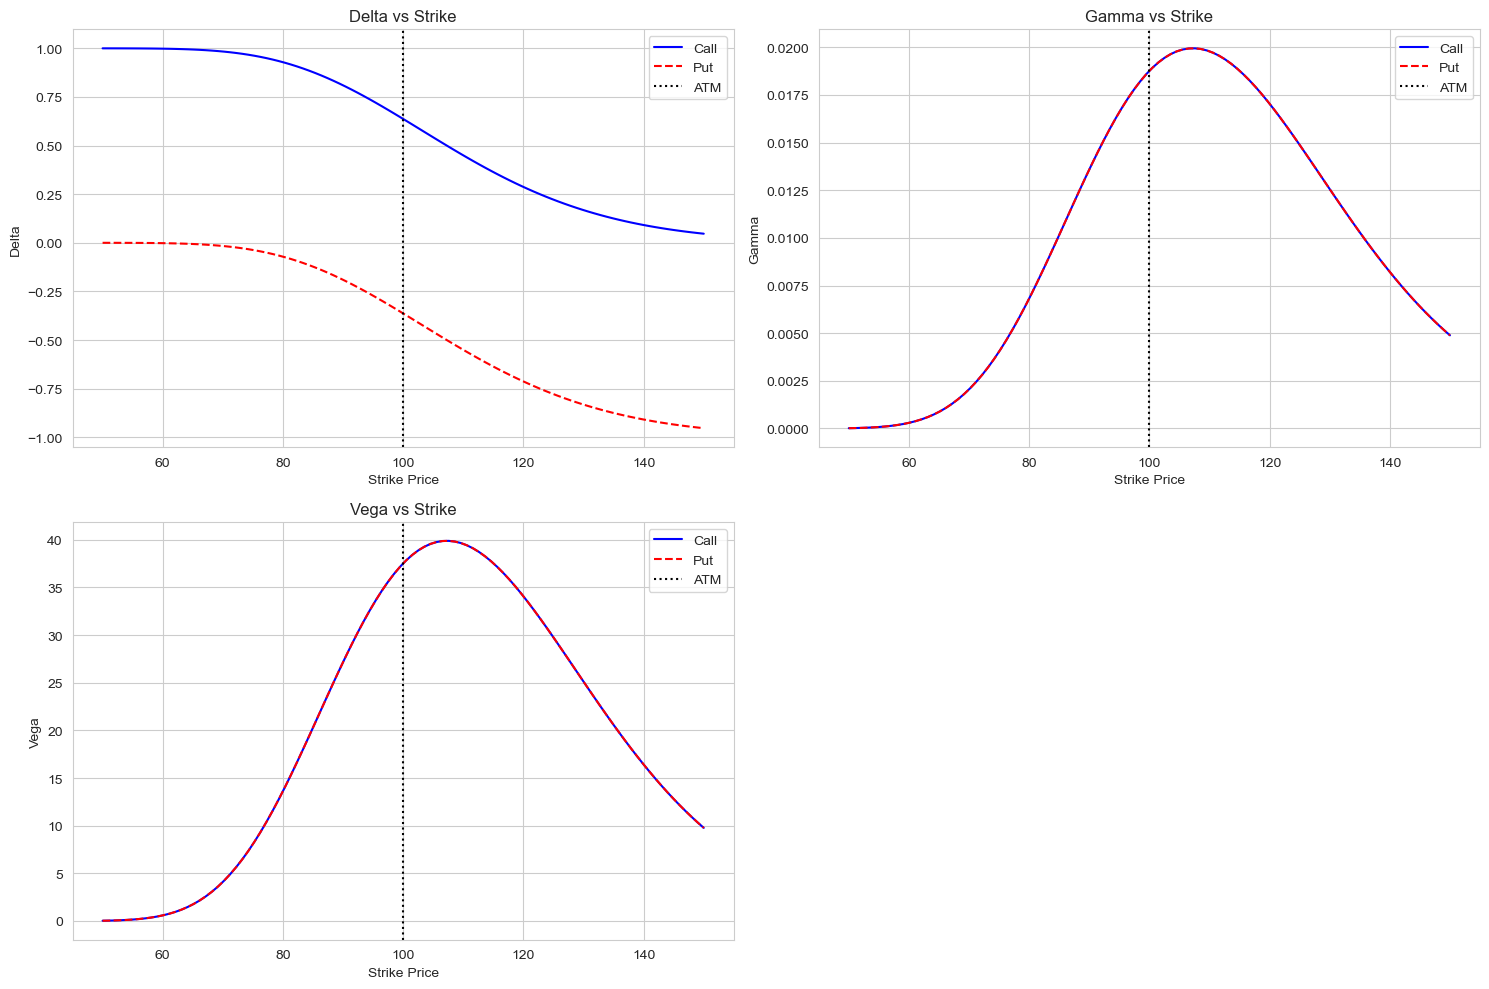

In [12]:
def greeks_validation_test():
    """Validate BS Greeks against benchmark values with visual confirmation"""
    # Benchmark parameters (J.C. Hull Example 19.6)
    S = 100
    K = 100
    T = 1.0
    r = 0.05
    sigma = 0.2
    q = 0.0    # No dividends

    # Expected values from verified sources (Hull)
    benchmark = {
        'call': {
            'delta': 0.6368,
            'gamma': 0.0188,
            'vega': 39.6635,
            'theta': -0.0114,  # Daily decay
            'rho': 53.0403
        },
        'put': {
            'delta': -0.3632,
            'gamma': 0.0188,    # Same as call
            'vega': 39.6635,    # Same as call
            'theta': -0.0050,   # Daily decay
            'rho': -41.4081
        }
    }

    # Run tests for both call and put
    results = {}
    for option_type in ['call', 'put']:
        greeks = bs_greeks(S, K, T, r, sigma, option_type, q)
        results[option_type] = greeks

        print(f"\n=== {option_type.upper()} Option Greeks Validation ===")
        print("{:<10} {:<15} {:<15} {:<10}".format(
            'Greek', 'Calculated', 'Benchmark', 'Error %'))

        for greek in benchmark[option_type]:
            calc = greeks[greek]
            expected = benchmark[option_type][greek]
            error_pct = 100 * abs(calc - expected) / expected if expected != 0 else 0

            print("{:<10} {:<15.6f} {:<15.6f} {:<10.2f}%".format(
                greek, calc, expected, error_pct))

    # Visual verification across strikes
    strikes = np.linspace(50, 150, 100)
    greek_maps = {
        'delta': {'call': [], 'put': []},
        'gamma': {'call': [], 'put': []},
        'vega': {'call': [], 'put': []}
    }

    for K_test in strikes:
        for option_type in ['call', 'put']:
            g = bs_greeks(S, K_test, T, r, sigma, option_type, q)
            for greek in greek_maps:
                greek_maps[greek][option_type].append(g[greek])

    plt.figure(figsize=(15, 10))
    for i, greek in enumerate(greek_maps, 1):
        plt.subplot(2, 2, i)
        plt.plot(strikes, greek_maps[greek]['call'], 'b-', label='Call')
        plt.plot(strikes, greek_maps[greek]['put'], 'r--', label='Put')
        plt.title(f'{greek.capitalize()} vs Strike')
        plt.xlabel('Strike Price')
        plt.ylabel(greek.capitalize())
        plt.axvline(S, color='k', linestyle=':', label='ATM')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    return results

validation_results = greeks_validation_test()

# **Performance Comparison**


---



In this analysis, I'm trying to understand how the **computation time** of the Binomial pricing model scales with the number of steps, and how it compares to the much **faster Black-Scholes formula**.
<br>I’ve kept all other parameters like spot price, strike, volatility, and time to maturity fixed, and varied only the number of steps in the Binomial tree.
<br>This helps decide which model to use depending on the **accuracy-speed tradeoff** in practical applications.


In [13]:
# Time the execution of both models
n_steps = 1000
n_repetitions = 100

# Time Black-Scholes
start = time.time()
for _ in range(n_repetitions):
    bs_price(S0, K, T, r, sigma, 'call', q)
bs_time = (time.time() - start) / n_repetitions

# Time Binomial
start = time.time()
for _ in range(n_repetitions):
    binomial_price(S0, K, T, r, sigma, n_steps, 'call', q)
binomial_time = (time.time() - start) / n_repetitions

print(f"Black-Scholes average time: {bs_time:.6f} seconds")
print(f"Binomial ({n_steps} steps) average time: {binomial_time:.6f} seconds")
print(f"Binomial is {binomial_time/bs_time:.1f}x slower than Black-Scholes")

Black-Scholes average time: 0.000077 seconds
Binomial (1000 steps) average time: 0.002706 seconds
Binomial is 35.2x slower than Black-Scholes


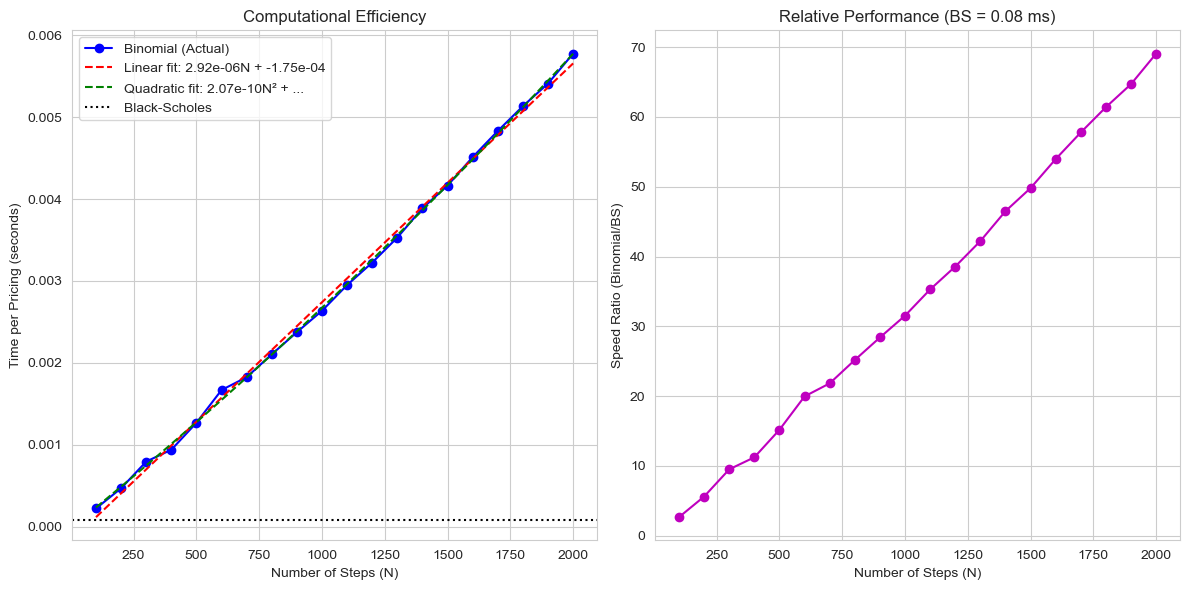


Key Insights:
1. Black-Scholes constant time: 0.08 ms
2. Binomial model complexity: Between O(N) and O(N²)
3. At N=2000:
   - Binomial time: 5.78 ms
   - 69x slower than Black-Scholes
4. Time per 1000 steps: 0.00292 ms (linear component)


In [14]:
def benchmark_models(S0, K, T, r, sigma, q, max_steps=2000, step_increment=100, repetitions=10):

    # Test different numbers of steps
    n_steps_range = range(step_increment, max_steps+1, step_increment)
    bs_times = []
    binomial_times = []

    # Benchmark Black-Scholes (constant time)
    start = time.time()
    for _ in range(repetitions):
        bs_price(S0, K, T, r, sigma, 'call', q)
    bs_time = (time.time() - start) / repetitions

    # Benchmark Binomial model across step counts
    for n in n_steps_range:
        start = time.time()
        for _ in range(repetitions):
            binomial_price(S0, K, T, r, sigma, n, 'call', q)
        binomial_times.append((time.time() - start) / repetitions)


    plt.figure(figsize=(12, 6))

    # Time complexity plot
    plt.subplot(1, 2, 1)
    plt.plot(n_steps_range, binomial_times, 'bo-', label=f'Binomial (Actual)')

    # Fit linear and quadratic trends
    coefficients_lin = np.polyfit(n_steps_range, binomial_times, 1)
    coefficients_quad = np.polyfit(n_steps_range, binomial_times, 2)

    plt.plot(n_steps_range,
             np.polyval(coefficients_lin, n_steps_range),
             'r--', label=f'Linear fit: {coefficients_lin[0]:.2e}N + {coefficients_lin[1]:.2e}')
    plt.plot(n_steps_range,
             np.polyval(coefficients_quad, n_steps_range),
             'g--', label=f'Quadratic fit: {coefficients_quad[0]:.2e}N² + ...')

    plt.axhline(bs_time, color='k', linestyle=':', label='Black-Scholes')
    plt.xlabel('Number of Steps (N)')
    plt.ylabel('Time per Pricing (seconds)')
    plt.title('Computational Efficiency')
    plt.legend()
    plt.grid(True)

    # Speed ratio plot
    plt.subplot(1, 2, 2)
    speed_ratios = [t/bs_time for t in binomial_times]
    plt.plot(n_steps_range, speed_ratios, 'mo-')
    plt.xlabel('Number of Steps (N)')
    plt.ylabel('Speed Ratio (Binomial/BS)')
    plt.title(f'Relative Performance (BS = {bs_time*1000:.2f} ms)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\nKey Insights:")
    print(f"1. Black-Scholes constant time: {bs_time*1000:.2f} ms")
    print(f"2. Binomial model complexity: Between O(N) and O(N²)")
    print(f"3. At N={max_steps}:")
    print(f"   - Binomial time: {binomial_times[-1]*1000:.2f} ms")
    print(f"   - {speed_ratios[-1]:.0f}x slower than Black-Scholes")
    print(f"4. Time per 1000 steps: {coefficients_lin[0]*1000:.5f} ms (linear component)")

benchmark_models(S0=346.46, K=311.81, T=0.5, r=0.05, sigma=0.2, q=0.005)

# **Error Analysis**


---



This analysis helps answer the questions:

1.   By ***how much*** does the value predicted by Binomial Tree differ from the BS-Price
2.   and at ***what rate*** does this error converge as N increases ?



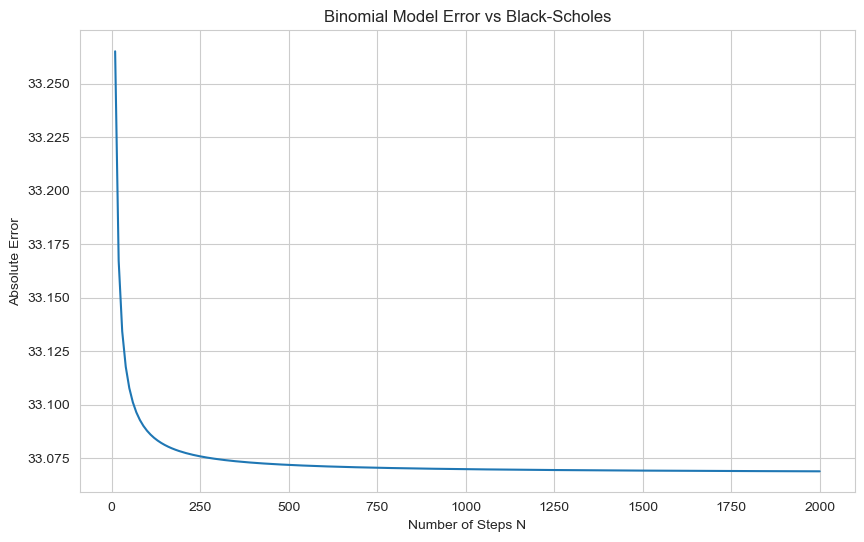

In [15]:
# Calculate and plot absolute errors
S0, K, T, r, sigma, q = 100, 100, 1, 0.05, 0.2, 0.0
n_values = np.arange(10, 2001, 10)
errors = []
for n in n_values:
    binom_val = binomial_price(S0, K, T, r, sigma, n, 'call', q)
    errors.append(abs(binom_val - bs_val))

plt.figure(figsize=(10,6))
plt.plot(n_values, errors)
plt.xlabel('Number of Steps N')
plt.ylabel('Absolute Error')
plt.title('Binomial Model Error vs Black-Scholes')
plt.grid(True)
plt.show()


Now I try to model the error as in the form $a.exp(N,b)$ to find the approximate rate of decay w.r.t number of steps N.

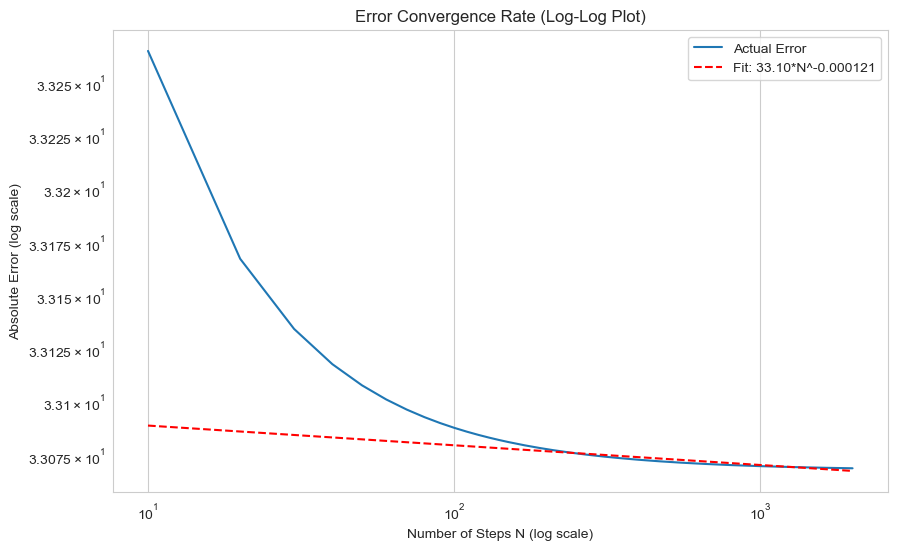

Error decreases approximately as N^-0.00012


In [16]:
# Fit a power law to the error
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x ** b

popt, pcov = curve_fit(power_law, n_values[10:], errors[10:])  # Use larger N for better fit
a, b = popt

plt.figure(figsize=(10,6))
plt.loglog(n_values, errors, label='Actual Error')
plt.loglog(n_values, power_law(n_values, a, b), 'r--',
           label=f'Fit: {a:.2f}*N^{b:.6f}')
plt.xlabel('Number of Steps N (log scale)')
plt.ylabel('Absolute Error (log scale)')
plt.title('Error Convergence Rate (Log-Log Plot)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Error decreases approximately as N^{b:.5f}")

**Expected Result**: Tree’s error shrinks on the order of 1/ sqrt(N)
​<br>(so doubling the number of steps cuts your discretization error by about 30%).

# **Sensitivity Analysis**


---



This analysis helps **visualize** the well known **relationship** between the various **parameters**  and the **Option Prices/Premiums**
<br>I have made sure to include the **results form both** the Binomial and Black-Scholes(BS) in the graph, though I must admit the graphs **more or less coincide** for number of steps (N) > 10<br>

General Trends:

| Variable                  | European Call | European Put | American Call | American Put |
|---------------------------|----------------|---------------|----------------|----------------|
| Current stock price       | +              | –             | +              | –              |
| Strike price              | –              | +             | –              | +              |
| Time to expiration        | ? (depends on divident)             | ? (depends on divident)            | +              | +              |
| Volatility                | +              | +             | +              | +              |
| Risk-free rate            | +              | –             | +              | –              |
| Amount of future dividends| –              | +             | –              | +              |


## With Volatility

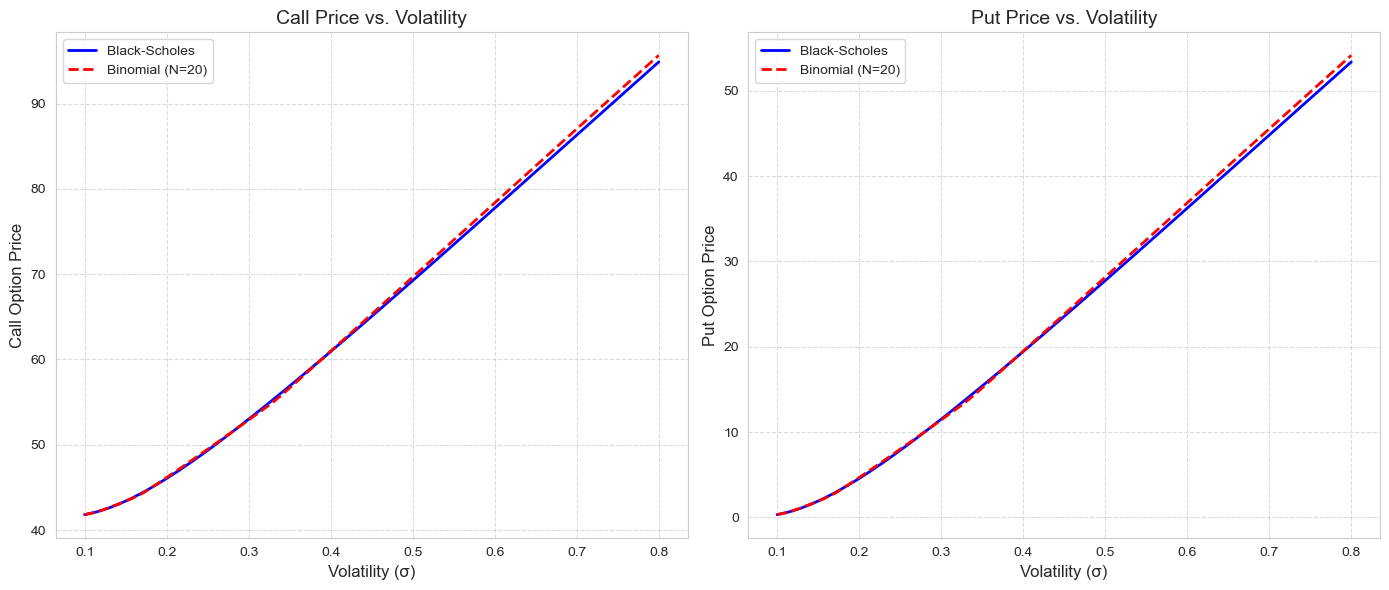

In [17]:
# Parameters
S0, K, T, r, q = 346.46, 311.81, 0.5, 0.05, 0.005
sigmas = np.linspace(0.1, 0.8, 50)  # Volatility range from 10% to 80%

# Initialize figure
plt.figure(figsize=(14, 6))

# --------------------------
# Call Options Subplot
# --------------------------
plt.subplot(1, 2, 1)

# Calculate prices
bs_calls = [bs_price(S0, K, T, r, s, 'call', q) for s in sigmas]
binom_calls = [binomial_price(S0, K, T, r, s, 20, 'call', q) for s in sigmas]

# Plot
plt.plot(sigmas, bs_calls, 'b-', label='Black-Scholes', linewidth=2)
plt.plot(sigmas, binom_calls, 'r--', label='Binomial (N=20)', linewidth=2)
plt.xlabel('Volatility (σ)', fontsize=12)
plt.ylabel('Call Option Price', fontsize=12)
plt.title('Call Price vs. Volatility', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# --------------------------
# Put Options Subplot
# --------------------------
plt.subplot(1, 2, 2)

# Calculate prices
bs_puts = [bs_price(S0, K, T, r, s, 'put', q) for s in sigmas]
binom_puts = [binomial_price(S0, K, T, r, s, 20, 'put', q) for s in sigmas]

# Plot
plt.plot(sigmas, bs_puts, 'b-', label='Black-Scholes', linewidth=2)
plt.plot(sigmas, binom_puts, 'r--', label='Binomial (N=20)', linewidth=2)
plt.xlabel('Volatility (σ)', fontsize=12)
plt.ylabel('Put Option Price', fontsize=12)
plt.title('Put Price vs. Volatility', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout()
plt.show()


## With Time to Maturity

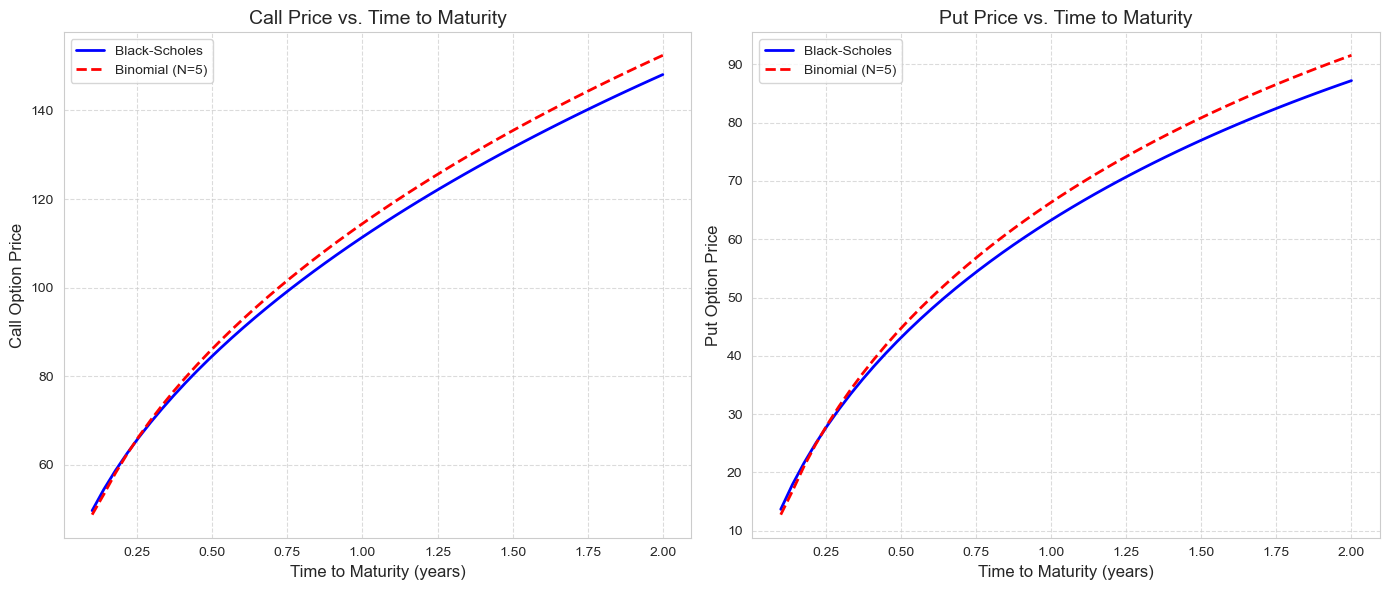

In [18]:
# Parameters
S0, K, r, sigma, q = 346.46, 311.81, 0.05, 0.68, 0.005
times = np.linspace(0.1, 2, 50)  # 1 month to 2 years

# Initialize figure
plt.figure(figsize=(14, 6))

# --------------------------
# Call Options Subplot
# --------------------------
plt.subplot(1, 2, 1)

# Calculate prices
bs_calls = [bs_price(S0, K, t, r, sigma, 'call', q) for t in times]
binom_calls = [binomial_price(S0, K, t, r, sigma, 5, 'call', q) for t in times]

# Plot
plt.plot(times, bs_calls, 'b-', label='Black-Scholes', linewidth=2)
plt.plot(times, binom_calls, 'r--', label='Binomial (N=5)', linewidth=2)
plt.xlabel('Time to Maturity (years)', fontsize=12)
plt.ylabel('Call Option Price', fontsize=12)
plt.title('Call Price vs. Time to Maturity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# --------------------------
# Put Options Subplot
# --------------------------
plt.subplot(1, 2, 2)

# Calculate prices
bs_puts = [bs_price(S0, K, t, r, sigma, 'put', q) for t in times]
binom_puts = [binomial_price(S0, K, t, r, sigma, 5, 'put', q) for t in times]

# Plot
plt.plot(times, bs_puts, 'b-', label='Black-Scholes', linewidth=2)
plt.plot(times, binom_puts, 'r--', label='Binomial (N=5)', linewidth=2)
plt.xlabel('Time to Maturity (years)', fontsize=12)
plt.ylabel('Put Option Price', fontsize=12)
plt.title('Put Price vs. Time to Maturity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout()
plt.show()

## With Risk-Free Rates

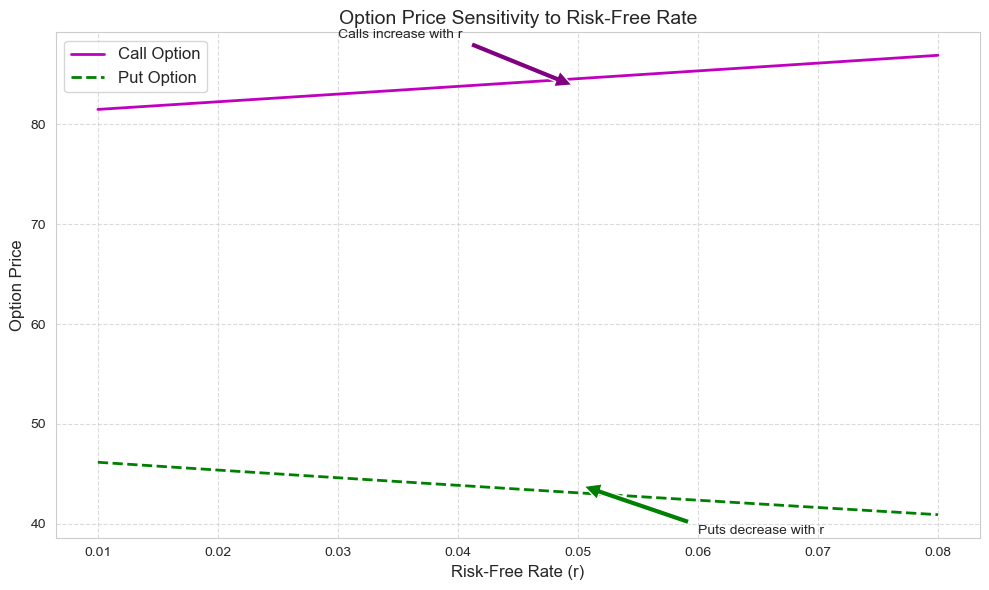

In [19]:
# Parameters
S0, K, T, sigma, q = 346.46, 311.81, 0.5, 0.68, 0.005

# Vary risk-free rate from 1% to 8%
rates = np.linspace(0.01, 0.08, 50)

# Calculate prices
call_prices = [bs_price(S0, K, T, r, sigma, 'call', q) for r in rates]
put_prices = [bs_price(S0, K, T, r, sigma, 'put', q) for r in rates]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(rates, call_prices, 'm-', label='Call Option', linewidth=2)
plt.plot(rates, put_prices, 'g--', label='Put Option', linewidth=2)

plt.xlabel("Risk-Free Rate (r)", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.title("Option Price Sensitivity to Risk-Free Rate", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate key points
plt.annotate('Calls increase with r',
             xy=(0.05, call_prices[20]), xytext=(0.03, call_prices[20]+5),
             arrowprops=dict(facecolor='purple', shrink=0.05))

plt.annotate('Puts decrease with r',
             xy=(0.05, put_prices[20]), xytext=(0.06, put_prices[20]-5),
             arrowprops=dict(facecolor='green', shrink=0.05))

plt.tight_layout()
plt.show()

## With Strike

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

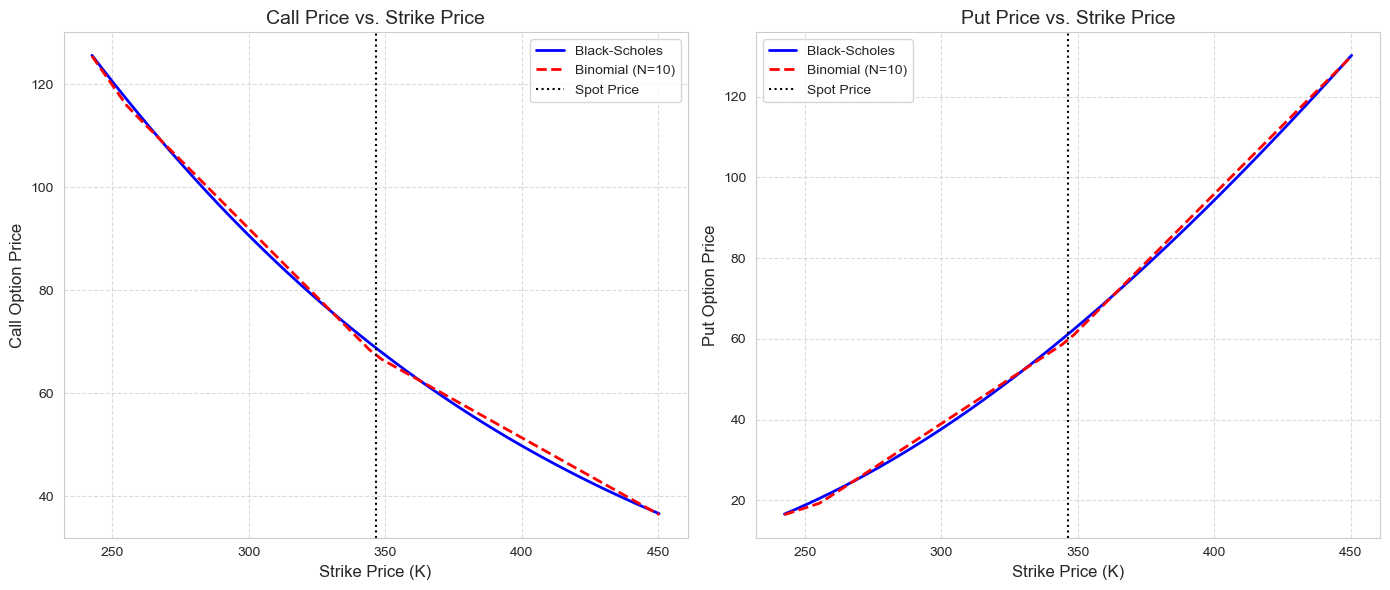

In [20]:
# Parameters
S0, T, r, sigma, q = 346.46, 0.5, 0.05, 0.68, 0.005
strikes = np.linspace(S0*0.7, S0*1.3, 50)  # 70% to 130% of Stock price (SPOT)

# Initialize figure
plt.figure(figsize=(14, 6))

# --------------------------
# Call Options Subplot
# --------------------------
plt.subplot(1, 2, 1)

# Calculate prices
bs_calls = [bs_price(S0, K, T, r, sigma, 'call', q) for K in strikes]
binom_calls = [binomial_price(S0, K, T, r, sigma, 10, 'call', q) for K in strikes]

# Plot
plt.plot(strikes, bs_calls, 'b-', label='Black-Scholes', linewidth=2)
plt.plot(strikes, binom_calls, 'r--', label='Binomial (N=10)', linewidth=2)
plt.axvline(S0, color='k', linestyle=':', label='Spot Price')
plt.xlabel('Strike Price (K)', fontsize=12)
plt.ylabel('Call Option Price', fontsize=12)
plt.title('Call Price vs. Strike Price', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# --------------------------
# Put Options Subplot
# --------------------------
plt.subplot(1, 2, 2)

# Calculate prices
bs_puts = [bs_price(S0, K, T, r, sigma, 'put', q) for K in strikes]
binom_puts = [binomial_price(S0, K, T, r, sigma, 10, 'put', q) for K in strikes]

# Plot
plt.plot(strikes, bs_puts, 'b-', label='Black-Scholes', linewidth=2)
plt.plot(strikes, binom_puts, 'r--', label='Binomial (N=10)', linewidth=2)
plt.axvline(S0, color='k', linestyle=':', label='Spot Price')
plt.xlabel('Strike Price (K)', fontsize=12)
plt.ylabel('Put Option Price', fontsize=12)
plt.title('Put Price vs. Strike Price', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout()
plt

# **Comparison With Market Prices**


---



## First analysis: Fixed expiration, varying strikes

In this analysis I have kept the **Time of Expiry/Maturity to be fixed** and **equal to the closest one to the current date**. Then I have predicted option **premiums/prices** using both models and compared it to the actual Market Price **w.r.t stock(spot) prices of various ATM options**.
<br>Thus I have calculated the **Mean Absolute Error** from both and taken their ratio.
<br>This can be done for various values of N.

In [24]:
def fetch_and_compare_options(ticker, moneyness_range=0.05, n_steps=50):
    """
    Fetches option chain data and compares market prices with model prices
    Returns: strikes, market_prices, bs_prices, binom_prices
    """

    calls, puts, expiration = fetch_option_chain(ticker)
    if calls is None:
        print("Could not fetch option chain data")
        return None, None, None, None, None, None, None

    today = datetime.now().date()
    spot_series = fetch_data(ticker, (today - timedelta(days=5)).strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))

    S0 = spot_series.iloc[-1]
    if hasattr(S0, 'iloc'):
      S0 = S0.iloc[0]
    else:
      S0 = float(S0)

    expiration_date = datetime.strptime(expiration, '%Y-%m-%d').date()
    T_market = (expiration_date - today).days / 365.25

    # Handle expired options
    if T_market <= 0:
        stock = yf.Ticker(ticker)
        future_expirations = [e for e in stock.options if datetime.strptime(e, '%Y-%m-%d').date() > today]
        if not future_expirations:
            print("No future expirations available")
            return None, None, None, None, None, None, None
        expiration = future_expirations[0]
        calls, puts, expiration = fetch_option_chain(ticker, expiration)
        expiration_date = datetime.strptime(expiration, '%Y-%m-%d').date()
        T_market = (expiration_date - today).days / 365.25


    print(f"Analyzing {ticker} options expiring on {expiration} (in {T_market*365:.1f} days)")

    # Filter for near ATM options
    strike_prices = calls['strike'].values
    mask = (strike_prices >= S0*(1-moneyness_range)) & (strike_prices <= S0*(1+moneyness_range))
    atm_calls = calls.iloc[mask]

    if len(atm_calls) == 0:
        print("No near-ATM options found")
        return None, None, None, None, None, None, None

    # Calculate prices
    strikes, market_prices, bs_prices, binom_prices = [], [], [], []
    q = get_dividend_yield(ticker)

    for _, row in atm_calls.iterrows():
        K_market = row['strike']
        market_price = row['lastPrice']
        if np.isnan(market_price) or market_price <= 0:
            continue

        sigma_market = row['impliedVolatility'] if not np.isnan(row['impliedVolatility']) else sigma
        if np.isnan(sigma_market) or sigma_market <= 0:
            continue

        bs_val = bs_price(S0, K_market, T_market, r, sigma_market, 'call', q)
        binom_val = binomial_price(S0, K_market, T_market, r, sigma_market, n_steps, 'call', q)

        if not np.isnan(bs_val) and not np.isnan(binom_val):
            strikes.append(K_market)
            market_prices.append(market_price)
            bs_prices.append(bs_val)
            binom_prices.append(binom_val)

    return strikes, market_prices, bs_prices, binom_prices, T_market, S0, expiration

In [25]:
def plot_and_analyze(sym, strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration):
    """Plots and analyzes the pricing results"""
    if not strikes:
        print("No valid data to plot")
        return

    plt.figure(figsize=(12,6))
    plt.plot(strikes, market_prices, 'o-', label='Market Price')
    plt.plot(strikes, bs_prices, 's--', label='Black-Scholes')
    plt.plot(strikes, binom_prices, '^--', label=f'Binomial')
    plt.axvline(S0_market, color='gray', linestyle='--', label='Current Price')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title(f'{sym} Option Prices (Exp: {expiration}, T={T_market:.2f} years)')
    plt.legend()
    plt.grid(True)
    plt.show()

    bs_errors = np.abs(np.array(bs_prices) - np.array(market_prices))
    binom_errors = np.abs(np.array(binom_prices) - np.array(market_prices))

    print(f"Black-Scholes avg error: ${np.mean(bs_errors):.4f}")
    print(f"Binomial avg error: ${np.mean(binom_errors):.4f}")
    print(f"Ratio: {np.mean(binom_errors)/np.mean(bs_errors):.2f}x")

    return np.mean(bs_errors), np.mean(binom_errors)

[*********************100%***********************]  1 of 1 completed


Analyzing SPY options expiring on 2025-06-16 (in 1.0 days)


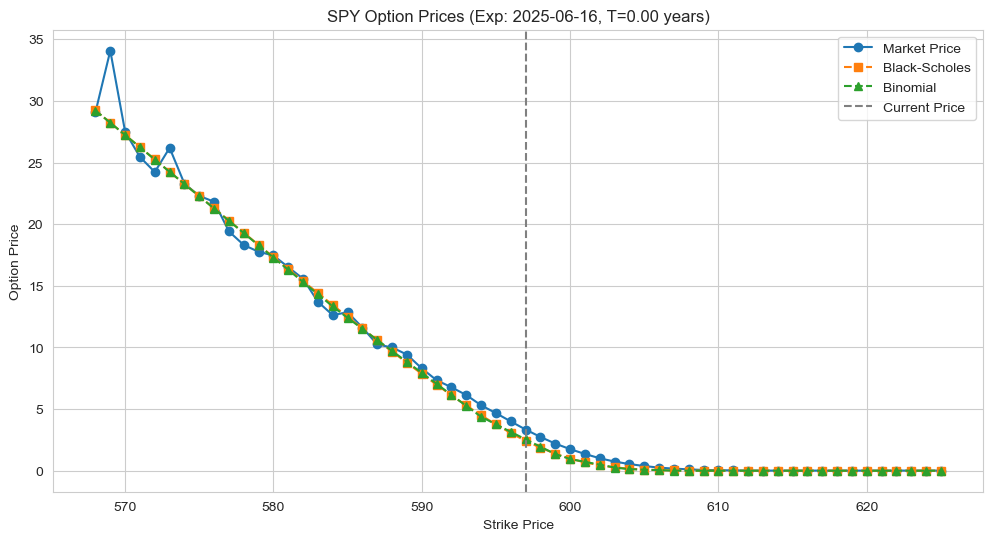

Black-Scholes avg error: $0.4872
Binomial avg error: $0.4814
Ratio: 0.99x


[*********************100%***********************]  1 of 1 completed


Analyzing QQQ options expiring on 2025-06-16 (in 1.0 days)


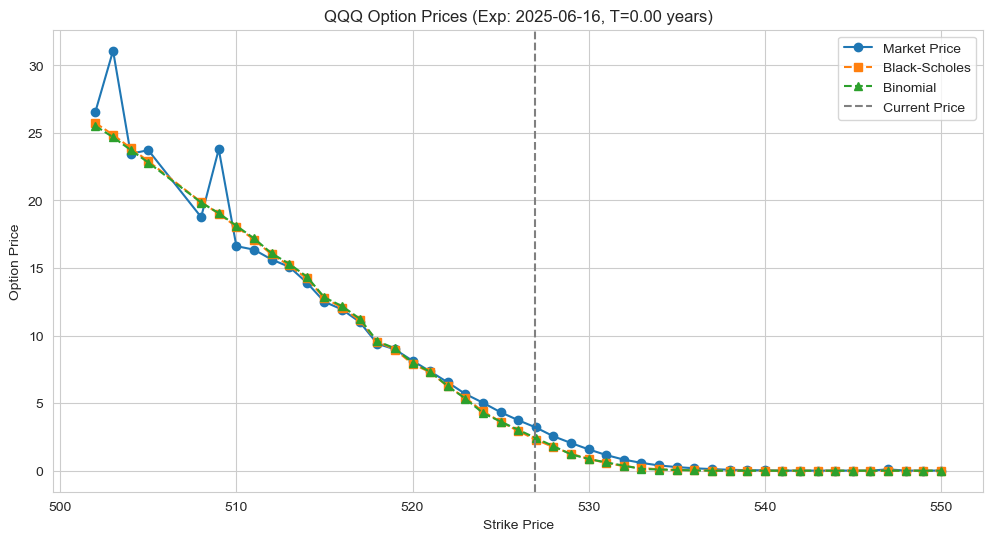

Black-Scholes avg error: $0.5660
Binomial avg error: $0.5876
Ratio: 1.04x


[*********************100%***********************]  1 of 1 completed


Analyzing DIA options expiring on 2025-06-20 (in 5.0 days)


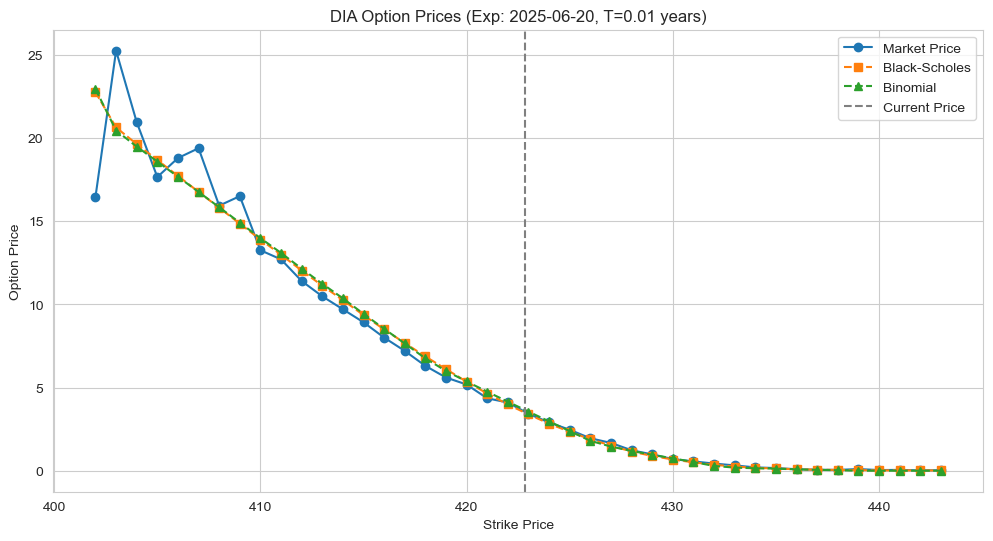

Black-Scholes avg error: $0.6085
Binomial avg error: $0.6374
Ratio: 1.05x


In [27]:
#Example 1
strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration = fetch_and_compare_options('SPY',0.05,5)
if strikes:
    fixed_exp_bs_err, fixed_exp_binom_err = plot_and_analyze(
        'SPY', strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration
    )

#Example 2
strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration = fetch_and_compare_options('QQQ',0.05,5)
if strikes:
    fixed_exp_bs_err, fixed_exp_binom_err = plot_and_analyze(
        'QQQ', strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration
    )


#Example 3
strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration = fetch_and_compare_options('DIA',0.05,5)
if strikes:
    fixed_exp_bs_err, fixed_exp_binom_err = plot_and_analyze(
        'DIA', strikes, market_prices, bs_prices, binom_prices, T_market, S0_market, expiration
    )

## Second analysis: Fixed strike (ATM), varying expiration

This time I have kept the **Stock (Spot) price constant** and equal to the most recent closing price of the underlying stock while varying the time to maturity and implied volatility across expirations.
<br>Here I have evaluated how **option pricing errors** (vs. market price) vary with **time to expiration** by analyzing **ATM call** options at different future dates.

In [28]:
def time_to_expiry_analysis(ticker='AAPL', n_steps=10, n_points=20):
    """Analyze pricing errors across different times to expiration"""
    # Get current data
    stock = yf.Ticker(ticker)
    S0 = stock.history(period='1d')['Close'].iloc[-1]
    q = get_dividend_yield(ticker)

    # Get available expirations
    expirations = stock.options
    today = datetime.now().date()
    future_expirations = [e for e in expirations if datetime.strptime(e, '%Y-%m-%d').date() > today]

    if not future_expirations:
        print("No future expirations available")
        return

    # Select evenly spaced expirations
    selected_expirations = future_expirations[:min(n_points, len(future_expirations))]
    if len(future_expirations) > n_points:
        selected_expirations = [future_expirations[i] for i in np.linspace(0, len(future_expirations)-1, n_points, dtype=int)]

    # Initialize results
    times = []
    bs_errors = []
    binom_errors = []
    strikes = []

    for expiration in selected_expirations:
        # Fetch option chain
        calls, puts, _ = fetch_option_chain(ticker, expiration)
        if calls is None:
            continue

        # Calculate time to expiration
        expiration_date = datetime.strptime(expiration, '%Y-%m-%d').date()
        T = (expiration_date - today).days / 365.25

        # Find ATM strike
        atm_call = calls.iloc[(calls['strike'] - S0).abs().argsort()[:1]]
        K = atm_call['strike'].values[0]
        market_price = atm_call['lastPrice'].values[0]
        sigma_market = atm_call['impliedVolatility'].values[0]

        if np.isnan(market_price) or market_price <= 0:
            continue

        # Calculate model prices
        bs_val = bs_price(S0, K, T, r, sigma_market, 'call', q)
        binom_val = binomial_price(S0, K, T, r, sigma_market, n_steps, 'call', q)

        if not np.isnan(bs_val) and not np.isnan(binom_val):
            times.append(T)
            strikes.append(K)
            bs_errors.append(abs(bs_val - market_price))
            binom_errors.append(abs(binom_val - market_price))

    # Plot results
    plt.figure(figsize=(12,5))
    plt.plot(times, bs_errors, 'bo-', label='Black-Scholes Error')
    plt.plot(times, binom_errors, 'ro-', label=f'Binomial Error (Steps = {n_steps})')
    plt.xlabel('Time to Expiration (years)')
    plt.ylabel('Absolute Error ($)')
    plt.title(f'Pricing Error vs Time to Expiration (ATM {ticker} Options)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return times, strikes, bs_errors, binom_errors

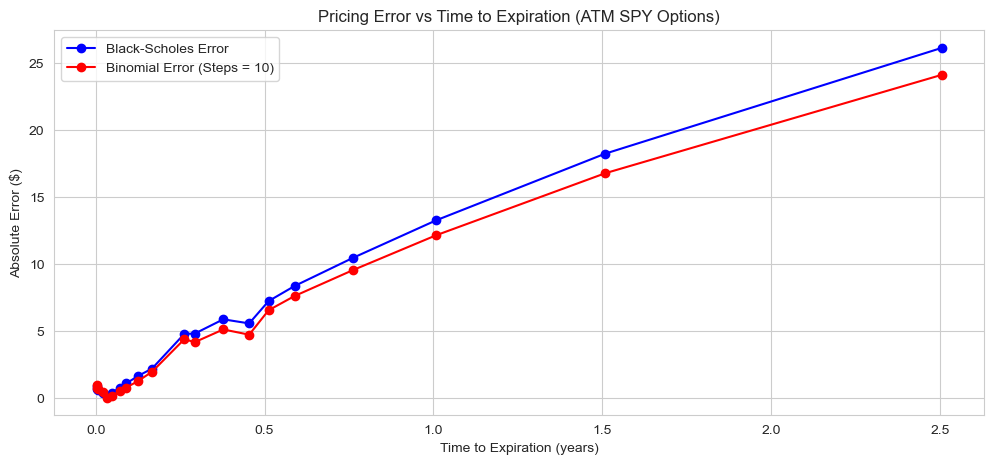

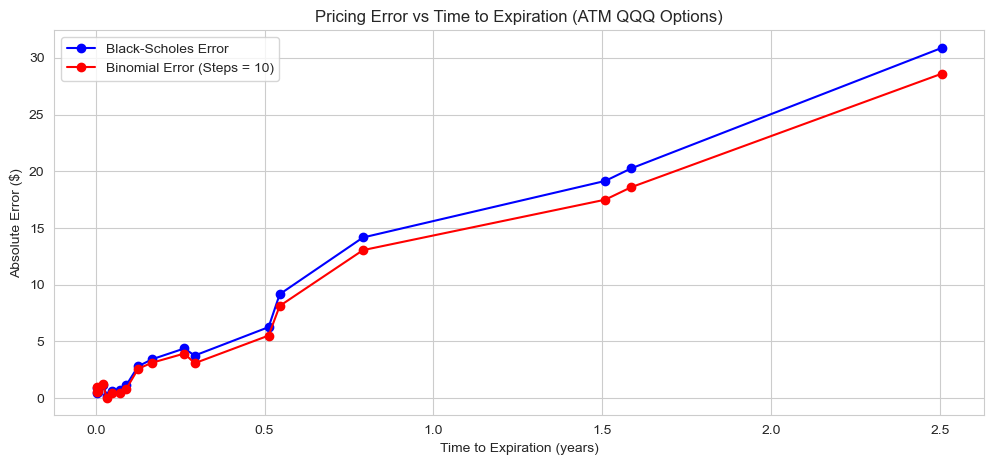

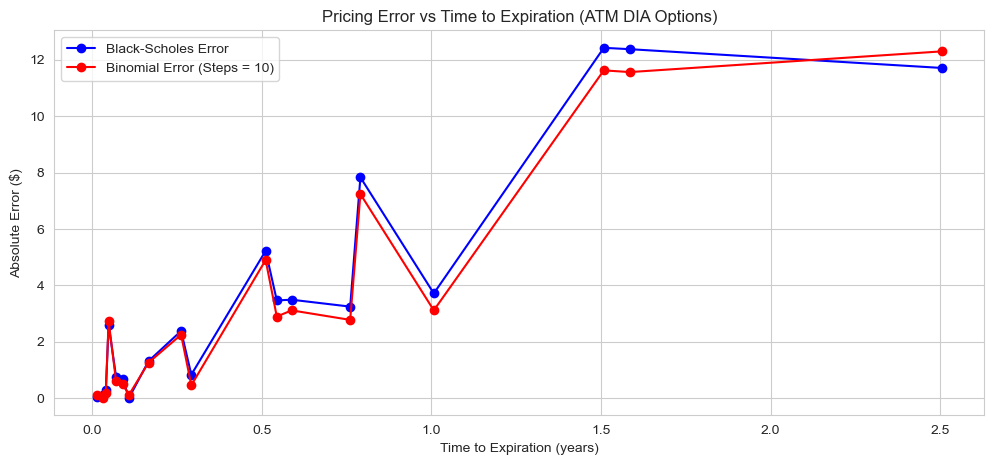

In [29]:
# example 1
times, strikes, bs_errors, binom_errors = time_to_expiry_analysis('SPY')
# example 2
times, strikes, bs_errors, binom_errors = time_to_expiry_analysis('QQQ')
#example 3
times, strikes, bs_errors, binom_errors = time_to_expiry_analysis('DIA')

### **Key Observations by Asset**
**SPY (S&P 500 ETF)** <br>
<br>**Trend**: Both Black-Scholes and Binomial errors increase almost linearly with time to expiration.
<br>**Magnitude**: Black-Scholes has slightly higher absolute errors across all maturities.
<br>**Low maturity**: For very short-dated options, both models perform well (errors < 1 dollar).
<br> **High maturity**: At 2.5 years, BS error exceeds 21 USD; Binomial ~ 19 USD.
<br><br>**Interpretation**: SPY’s dividend yield and volatility skew likely make BS less accurate for longer-dated options.
Binomial (even with just 10 steps!) manages to stay closer due to its discrete-time nature and better handling of dividends.
<br><br><br>
**QQQ (NASDAQ-100 ETF)**<br>
<br>**Trend**: Similar to SPY — steady error growth with maturity.
<br>**Magnitude**: Errors are higher than SPY — reaching 27 USD  for BS and 24 USD for Binomial. Critical jump around 0.6–0.8 years, possibly due to known earnings cycles or volatility kinks.
<br><br>**Interpretation**: QQQ is tech-heavy, with higher implied volatilities and earnings sensitivity, which amplifies model error. Again, Binomial outperforms BS slightly, even with 10 steps.
<br><br><br>
**DIA (Dow Jones ETF)**<br>
<br>**Trend**: Noisy and irregular, errors don’t grow smoothly with time.
<br>**Magnitude**: Lower overall errors compared to SPY/QQQ.
<br>**Volatility**: Large fluctuation at ~1.5 years, but flattens beyond that.
<br><br>**Interpretation**: DIA comprises large, stable industrial stocks, less volatility and option complexity → models perform better.
The non-monotonic error could suggest inconsistent market pricing or low liquidity in long-dated DIA options.